# Packages

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels as sm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa as tsa
from statsmodels.tsa.seasonal import seasonal_decompose as sd
import plotly.graph_objects as go
import pandas.testing
import missingno as msno

In [8]:
#pip install Prophet
#pip install plotly --upgrade

In [9]:
#pip install plotly --upgrade

In [10]:


from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# Load dataset

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Here I am importing all the dataset files from google Drive

features = pd.read_csv('drive/MyDrive/MK/features.csv')
stores = pd.read_csv('drive/MyDrive/MK/stores.csv')
train = pd.read_csv('drive/MyDrive/MK/train.csv')
test = pd.read_csv('drive/MyDrive/MK/test.csv')

In [13]:
#Displaying all the dataset 
# In OUTPUT we can see that all the dataset have 1 column in common, that is storeid.
 
print(features.head(5))
print('\n')
print(stores.head(5))
print('\n')
print(train.head(5))
print('\n')
print(test.head(5))

   Store        Date  Temperature  ...         CPI  Unemployment  IsHoliday
0      1  2010-02-05        42.31  ...  211.096358         8.106      False
1      1  2010-02-12        38.51  ...  211.242170         8.106       True
2      1  2010-02-19        39.93  ...  211.289143         8.106      False
3      1  2010-02-26        46.63  ...  211.319643         8.106      False
4      1  2010-03-05        46.50  ...  211.350143         8.106      False

[5 rows x 12 columns]


   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875


   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False


   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      F

In [14]:
#Here I am checking the shape of all the dataset files.

print('features', features.shape)
print('stores', stores.shape)
print('train', train.shape)
print('test', test.shape)

features (8190, 12)
stores (45, 3)
train (421570, 5)
test (115064, 4)


# Data Cleaning

In [15]:
#Here I ma merging Feature DAtaset with the Stores dataset.
#I am using Left join for joining dataset because I only want the store details that is available in feature dataset.
#both dataset are linked with eachother on storeid

merge1 = train.merge(features, 'left').merge(stores, 'left')

In [16]:
merge1.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [17]:
#Here i am merging another file train with the Merge1 files thye main reason behinf to merge this file is, ytrain dataset contains Weekly_Sales records which i needed for visualization and to train the model.
#dataframe Final_dataframe is my final dataframe 

Final_dataframe = train.merge(merge1, 'left').merge(train, 'left')

In [18]:
#here I am check the null values in all the columns.

#The Markdown1,Markdown1,Markdown2,Markdown3, Markdown4, Markdown5

# Markdown 1 to 5 is Anonymized data related to promotional markdowns that Walmart is running. 
# Markdown data is only available after November 2011, and is not available for all stores all the time. 
# Any missing value is marked with Null.

Final_dataframe.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [19]:
#Here I decided to remove Markdown columns from the dataframe because I think rightnow it is not useful 

clean_dataframe = Final_dataframe.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis = 1)

In [20]:
# Percentage of missing Values

clean_dataframe.isna().sum()/len(clean_dataframe)*100

Store           0.0
Dept            0.0
Date            0.0
Weekly_Sales    0.0
IsHoliday       0.0
Temperature     0.0
Fuel_Price      0.0
CPI             0.0
Unemployment    0.0
Type            0.0
Size            0.0
dtype: float64

In [21]:
clean_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   CPI           421570 non-null  float64
 8   Unemployment  421570 non-null  float64
 9   Type          421570 non-null  object 
 10  Size          421570 non-null  int64  
dtypes: bool(1), float64(5), int64(3), object(2)
memory usage: 35.8+ MB


In [22]:
#Here I am converting Date column to DATETIME. 
#I am doing this because I want to extract the data from Date columns.

clean_dataframe['Date'] = pd.to_datetime(clean_dataframe['Date'])

In [23]:
#Here I am extracting Week and Year records from Date columns and putting them in the new columns

clean_dataframe['week'] = clean_dataframe.Date.dt.isocalendar().week
clean_dataframe['year'] = clean_dataframe.Date.dt.isocalendar().year


In [24]:
# For extra Day and Month I use different code necause I was getting error while extracting Month record and I was getting same value in Day.
clean_dataframe["Day"] = pd.DatetimeIndex(clean_dataframe['Date']).day
clean_dataframe['Month'] = pd.DatetimeIndex(clean_dataframe['Date']).month


In [25]:
clean_dataframe.replace({False: 0, True: 1}, inplace=True)

In [26]:
clean_dataframe.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,week,year,Day,Month
0,1,1,2010-02-05,24924.50,0,42.31,2.572,211.096358,8.106,A,151315,5,2010,5,2
1,1,1,2010-02-12,46039.49,1,38.51,2.548,211.242170,8.106,A,151315,6,2010,12,2
2,1,1,2010-02-19,41595.55,0,39.93,2.514,211.289143,8.106,A,151315,7,2010,19,2
3,1,1,2010-02-26,19403.54,0,46.63,2.561,211.319643,8.106,A,151315,8,2010,26,2
4,1,1,2010-03-05,21827.90,0,46.50,2.625,211.350143,8.106,A,151315,9,2010,5,3


# EDA

## **Which store has maximum sales ?**
#### Here I am checking each store sales by comparing with other stores by Weekly_Sales

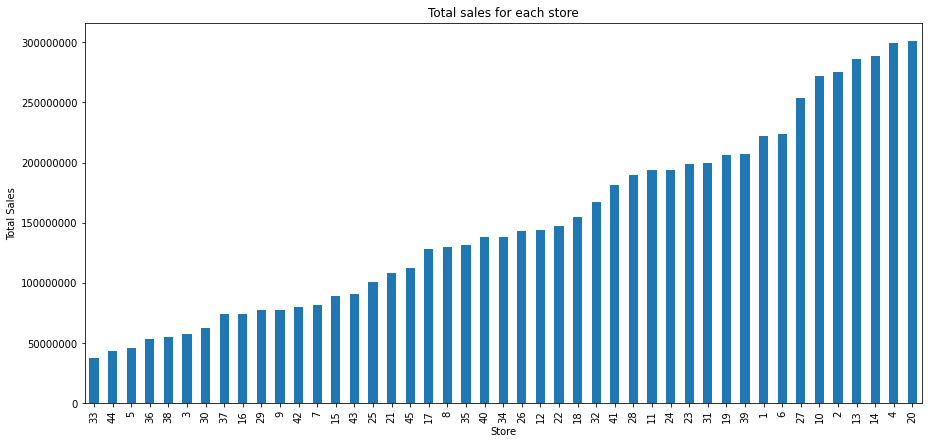

In [25]:
total_sales = clean_dataframe.groupby('Store')['Weekly_Sales'].sum().sort_values() 
total_sales_array = np.array(total_sales)
plt.figure(figsize=(15,7))
plt.xticks(rotation=0)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Total sales for each store')
plt.xlabel('Store')
plt.ylabel('Total Sales')
total_sales.plot(kind='bar')

### Here from the Bar chart we can assume that Storeid 20, 4 had maximum sales compare to other stores however, storeid 33,44,5 and 36 had wrost sales



## **Which stores has best quarterly growth rate in year 2012 ?**

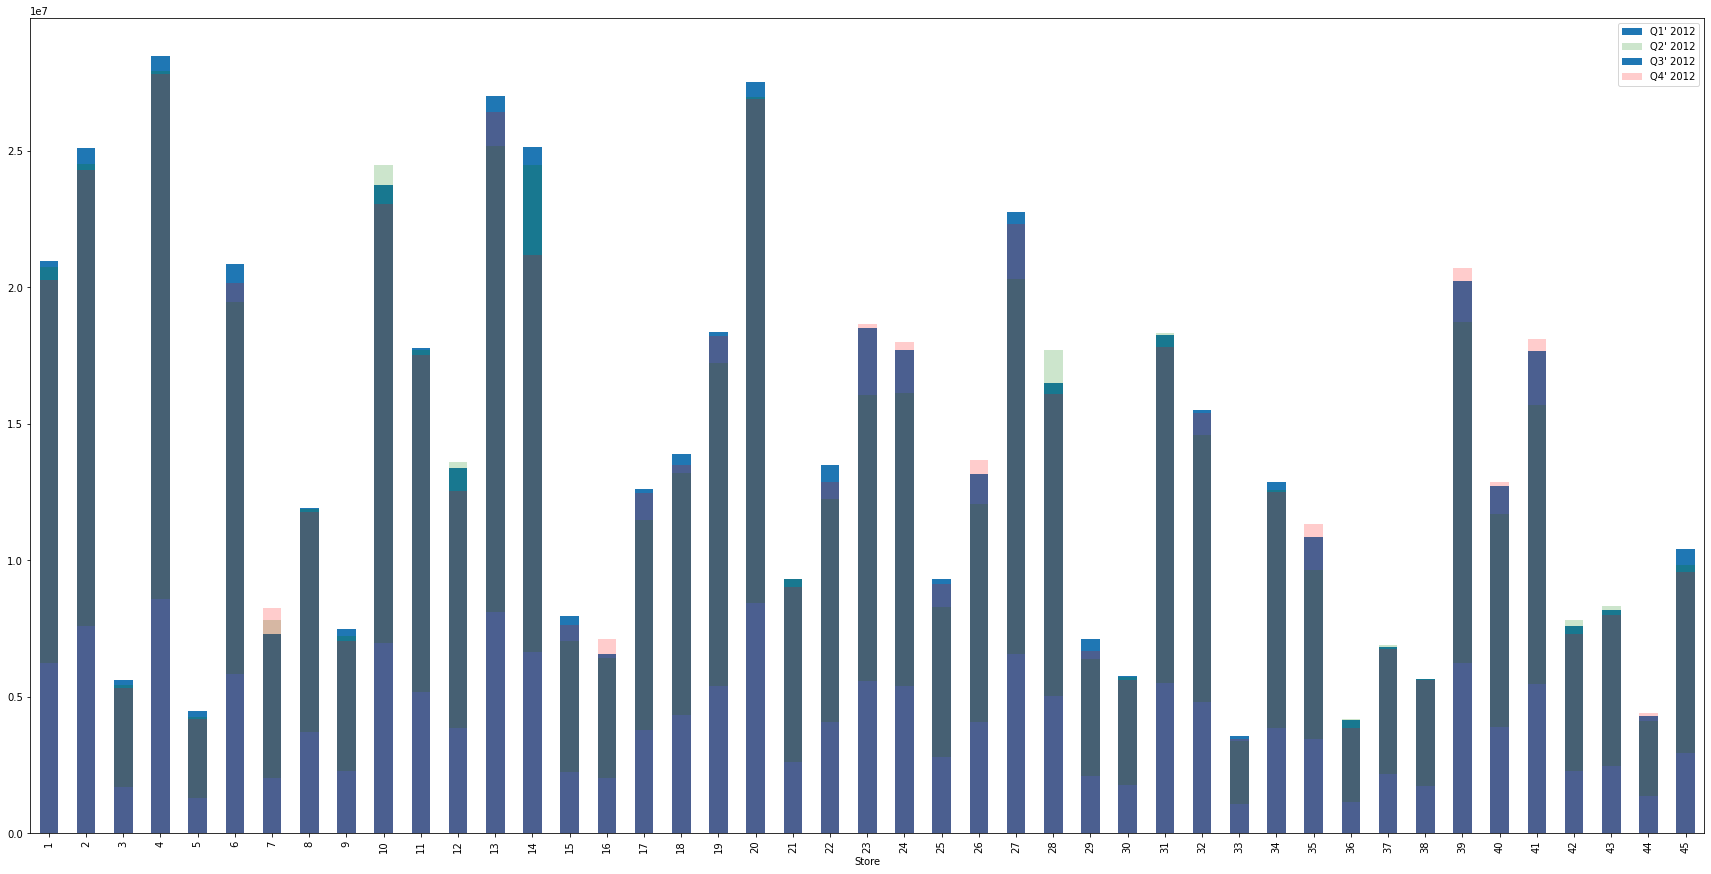

In [26]:
# Sales for second and third quarter in 2012
quarter_1_sales = clean_dataframe[(clean_dataframe['Date'] >= '2012-01-01') & (clean_dataframe['Date'] <= '2012-03-30')].groupby('Store')['Weekly_Sales'].sum()
quarter_2_sales = clean_dataframe[(clean_dataframe['Date'] >= '2012-04-01') & (clean_dataframe['Date'] <= '2012-06-30')].groupby('Store')['Weekly_Sales'].sum()
quarter_3_sales = clean_dataframe[(clean_dataframe['Date'] >= '2012-07-01') & (clean_dataframe['Date'] <= '2012-09-30')].groupby('Store')['Weekly_Sales'].sum()
quarter_4_sales = clean_dataframe[(clean_dataframe['Date'] >= '2012-10-01') & (clean_dataframe['Date'] <= '2012-12-31')].groupby('Store')['Weekly_Sales'].sum()

# Plotting the difference between sales for second and third quarterly
plt.figure(figsize=(30,15))
quarter_1_sales.plot(ax = quarter_2_sales.plot(kind ='bar'), kind='bar', color='g', alpha=0.2, legend=True)
quarter_3_sales.plot(ax = quarter_4_sales.plot(kind ='bar'), kind='bar', color='red', alpha=0.2, legend=True)

plt.legend(["Q1' 2012", "Q2' 2012", "Q3' 2012", "Q4' 2012"])

### **I campare all the quater records with reach other and I found that Store No 4 have highest growth in 3rd quarter**

#### After finding this , I decided to check the Growthrate of store in year 2012. To calculate that I decided to compare Q3 data with Q2 data.

In [27]:
#Calculating Growth rate in Q3'2012

quarter_2_sales= clean_dataframe[(clean_dataframe['Date'] >= '2012-04-01') & (clean_dataframe['Date'] <= '2012-06-30')].groupby('Store')['Weekly_Sales'].sum()
quarter_3_sales= clean_dataframe[(clean_dataframe['Date'] >= '2012-07-01') & (clean_dataframe['Date'] <= '2012-09-30')].groupby('Store')['Weekly_Sales'].sum()
quarterly_growth_rate = ((quarter_3_sales - quarter_2_sales )/quarter_2_sales)*100
quarterly_growth_rate.sort_values(ascending=False).head(5)

Store
7     13.330776
16     8.488378
35     4.466637
26     3.955478
39     2.478404
Name: Weekly_Sales, dtype: float64

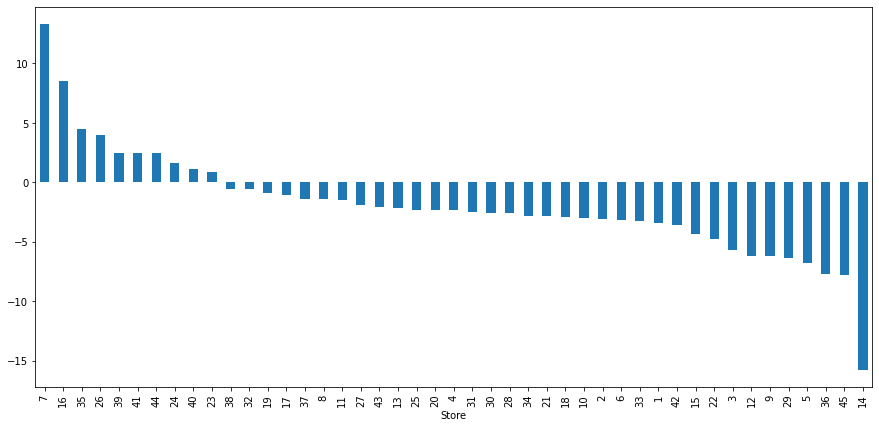

In [28]:
plt.figure(figsize=(15,7))
quarterly_growth_rate.sort_values(ascending=False).plot(kind='bar')

#### On the Above OUTPUT we can see that store no 7,16,35 have the beast growth rate ehich means it perform better in Q3 compared to Q2. Store No 7 perform 13% better compared to Q2 and store No 14 and 45 have the wrost growth rate.

## **Holidays impact on sales.**

### WE all know that Holiday always make significant impact on sales however not all the holidays make impact. Here I will visualize which holidays does not make any or less impact on sales. 


`Holiday Events:`



1.  Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

2.  Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

3.  Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13



In [29]:
#Defining holiday dates

Labour_Day =  ['10-9-2010', '9-9-2011', '7-9-2012']
Thanksgiving = ['26-11-2010', '25-11-2011', '23-11-2012']
Christmas = ['31-12-2010', '30-12-2011', '28-12-2012']

In [30]:
#Calculating mean sales on holidays : 

Labour_Day_Sales = (pd.DataFrame(clean_dataframe.loc[clean_dataframe.Date.isin(Labour_Day)]))['Weekly_Sales'].mean()
Thanksgiving_Sales = (pd.DataFrame(clean_dataframe.loc[clean_dataframe.Date.isin(Thanksgiving)]))['Weekly_Sales'].mean()
Christmas_Sales = (pd.DataFrame(clean_dataframe.loc[clean_dataframe.Date.isin(Christmas)]))['Weekly_Sales'].mean()

In [31]:
print('Mean of Labour Day Sales', Labour_Day_Sales)
print('Mean of Thanksgiving Sales', Thanksgiving_Sales)
print('Mean of Christmas Sales', Christmas_Sales)


Mean of Labour Day Sales 15809.06948275864
Mean of Thanksgiving Sales 22220.944537674088
Mean of Christmas Sales 14543.387157753083


In [32]:
#Calculating mean sales on non-holidays :
Non_Holiday_Sales = clean_dataframe[clean_dataframe['IsHoliday'] == 0 ]['Weekly_Sales'].mean()
Non_Holiday_Sales

15901.445069008516

In [33]:
Mean_Sales = {'Labour_Day_Sales': Labour_Day_Sales,
              'Thanksgiving_Sales':Thanksgiving_Sales,
              'Christmas_Sales': Christmas_Sales,
              'Non_Holiday_Sales': Non_Holiday_Sales}
Mean_Sales 

{'Christmas_Sales': 14543.387157753083,
 'Labour_Day_Sales': 15809.06948275864,
 'Non_Holiday_Sales': 15901.445069008516,
 'Thanksgiving_Sales': 22220.944537674088}

#### Clearly, Thanksgiving has higher sales than the mean sales on non-holidays.

## **Visualizing monthly view of sales in units and its insights.**

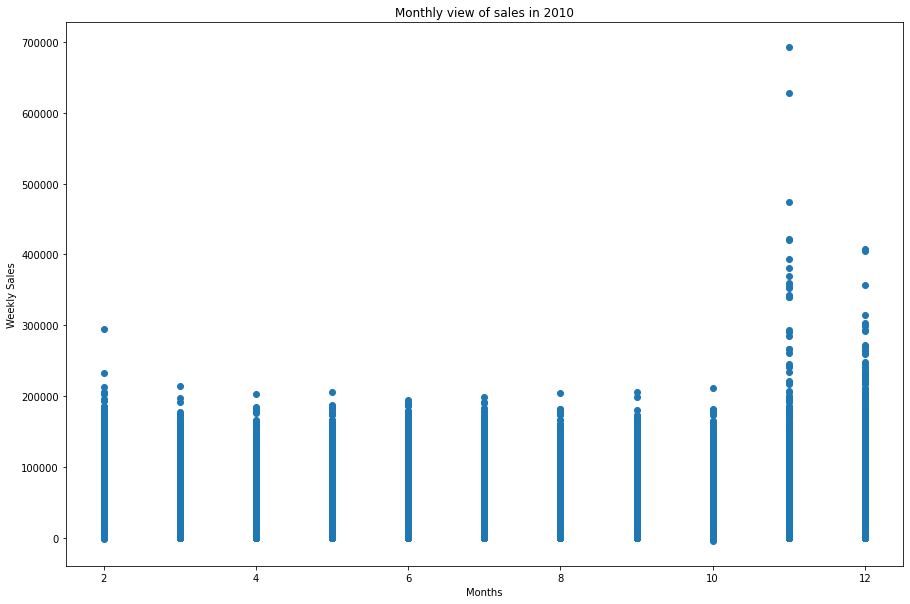

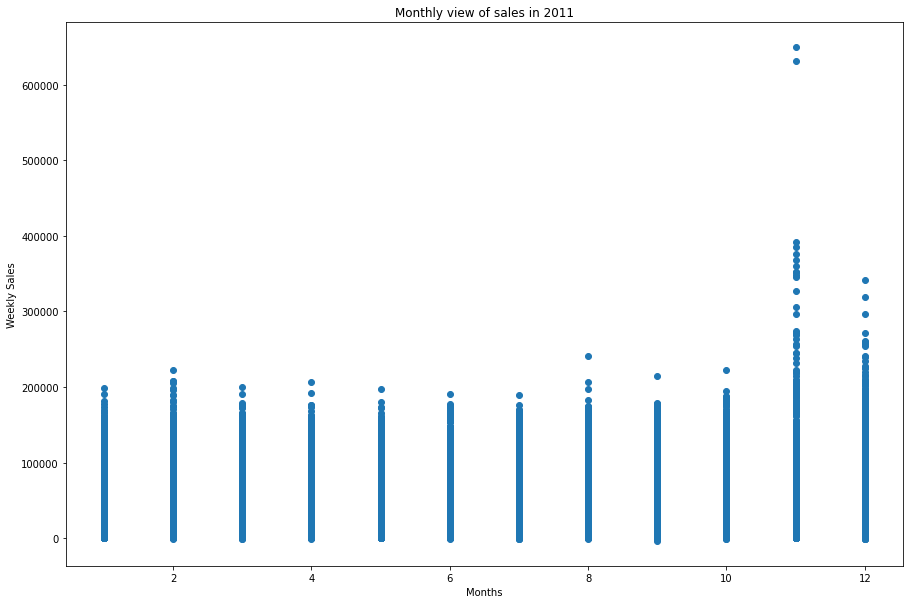

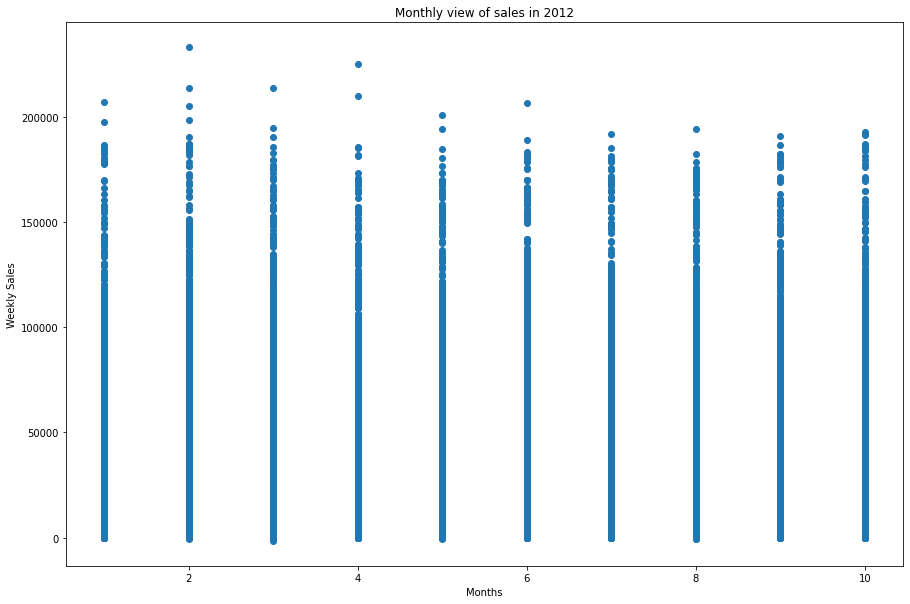

In [34]:
#Year-wise Monthly Sales


#Here I am making 3 seprate graph of 2010, 2011 and 2012 
plt.figure(figsize=(15,10))
plt.scatter(clean_dataframe[clean_dataframe.year == 2010]["Month"],clean_dataframe[clean_dataframe.year == 2010]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2010")
plt.show()

plt.figure(figsize=(15,10))
plt.scatter(clean_dataframe[clean_dataframe.year == 2011]["Month"],clean_dataframe[clean_dataframe.year == 2011]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2011")
plt.show()

plt.figure(figsize=(15,10))
plt.scatter(clean_dataframe[clean_dataframe.year == 2012]["Month"],clean_dataframe[clean_dataframe.year == 2012]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2012")
plt.show()

### From above 3 plots onw thing is clear that in year 2012 Sales growth rate increase tremendously. 

## **Overall Monthly Sales**

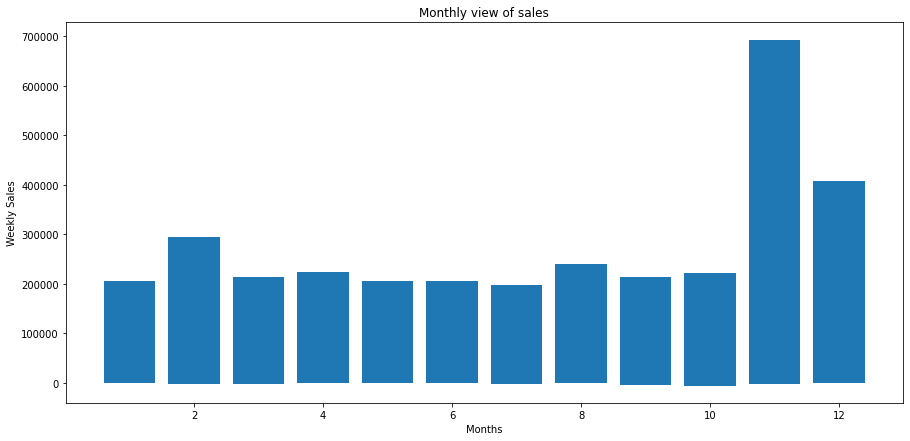

In [35]:
plt.figure(figsize=(15,11))
plt.bar(clean_dataframe["Month"],clean_dataframe["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales")
plt.show()

### In Above plot we can see that, overall monthly sales are higher in the month of November and December. The reason behind this Holidays like Thanksgiving and Black Friday were came in November and Christmas Holidays are in December.

# Model 1 Random Forest Regressor Model 

### **Now I am Building Prediction Model for Store to Forecast Demand. Here I am using Random Forest Regressor Model. I choose this model because I think for this dataset this is the best model. It has lot of Advantes like it uses averaging to improve the predictive accuracy and control over-fitting. In model I will Utilize variables like date and restructure dates as 1 for 5 Feb 2010. Hypothesize if CPI, unemployment, and fuel price have any impact on sales. Change dates into days by creating new variable.**

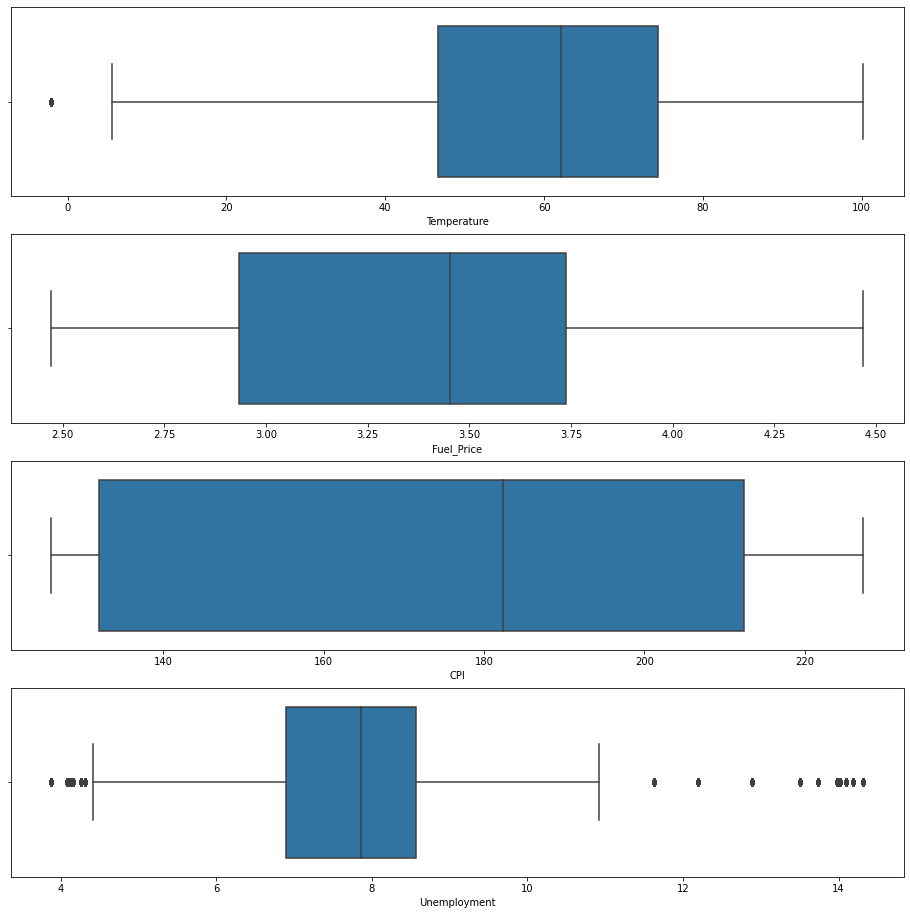

In [87]:
#First I will check that any outlier present in data 

fig, axis = plt.subplots(4,figsize=(16,16))
X = clean_dataframe[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(clean_dataframe[column],ax=axis[i])

### I have detect some outliers in the unemployment columns.

In [88]:
# Here in this code I am removeing outliers that are present in the Unemployment column.
#here i am taking only records that have Unemployment rate less than 10 and above 4.5

clean_dataframe = clean_dataframe[(clean_dataframe['Unemployment'] < 10) & (clean_dataframe['Unemployment'] > 4.5) ]
clean_dataframe

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,week,year,Day,Month
0,1,1,2010-02-05,24924.50,0,42.31,2.572,211.096358,8.106,A,151315,5,2010,5,2
1,1,1,2010-02-12,46039.49,1,38.51,2.548,211.242170,8.106,A,151315,6,2010,12,2
2,1,1,2010-02-19,41595.55,0,39.93,2.514,211.289143,8.106,A,151315,7,2010,19,2
3,1,1,2010-02-26,19403.54,0,46.63,2.561,211.319643,8.106,A,151315,8,2010,26,2
4,1,1,2010-03-05,21827.90,0,46.50,2.625,211.350143,8.106,A,151315,9,2010,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,0,64.88,3.997,192.013558,8.684,B,118221,39,2012,28,9
421566,45,98,2012-10-05,628.10,0,64.89,3.985,192.170412,8.667,B,118221,40,2012,5,10
421567,45,98,2012-10-12,1061.02,0,54.47,4.000,192.327265,8.667,B,118221,41,2012,12,10
421568,45,98,2012-10-19,760.01,0,56.47,3.969,192.330854,8.667,B,118221,42,2012,19,10


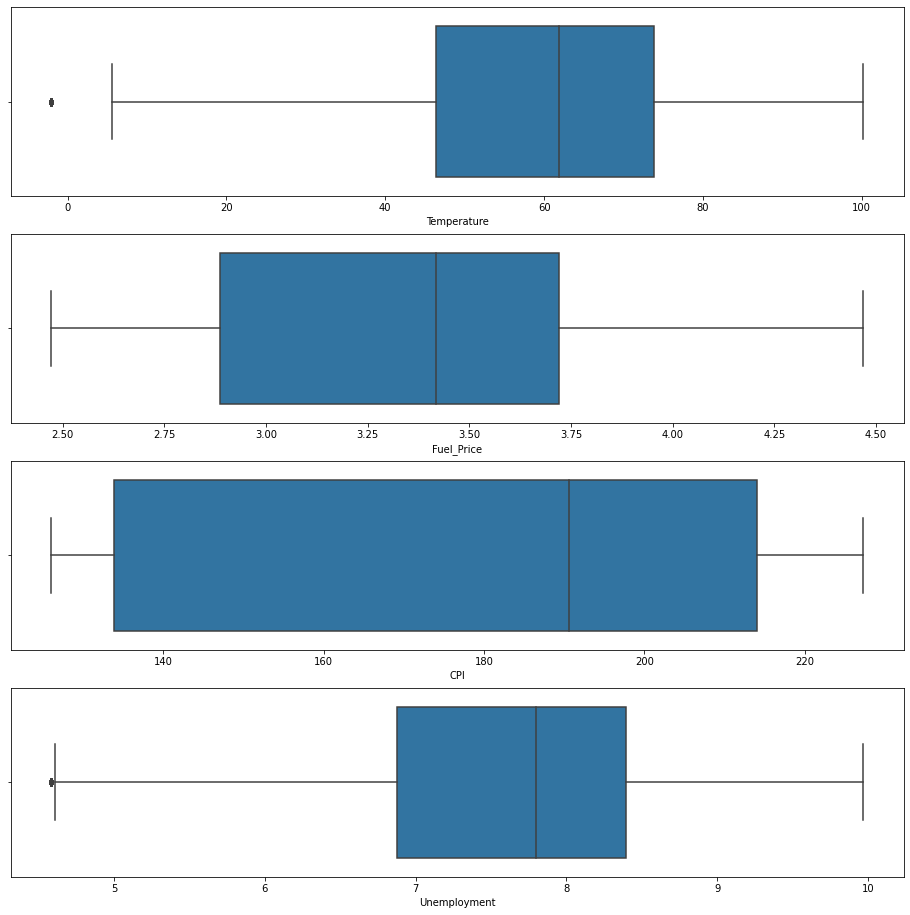

In [89]:
#After removing outliers from the dataset here i am checking again for any poutliers present or not
fig, axis = plt.subplots(4,figsize=(16,16))
X = clean_dataframe[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(clean_dataframe[column], ax=axis[i])


In [117]:
# Random Forest Regressor

# Variable X contains the Features columns 
# Variable Y contains the Target Variable which is Weekly Sales

X = clean_dataframe[['Store','Fuel_Price','CPI','Unemployment','Day','Month','year','IsHoliday']]
Y = clean_dataframe['Weekly_Sales']

#Below code I am spliting dataset whwere 70% data will used as Training data and 30% of DAta will bes used as Testing data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3)

#I am using Random Forest Model with the n_estimators 120
Random_Regressor_model = RandomForestRegressor(n_estimators = 120)        
Random_Regressor_model.fit(X_train,Y_train)

Y_pred = Random_Regressor_model.predict(X_test)

print('Accuracy:',Random_Regressor_model.score(X_test, Y_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))


Accuracy: 7.426683818191182
Mean Absolute Error: 14562.940620769647
Mean Squared Error: 496224863.38179994
Root Mean Squared Error: 22276.10521123026


## Random Forest Regressor model gives accuracy of around 74%